<a href="https://colab.research.google.com/github/carlosdg/NeuralStyleTransfer/blob/master/GatysStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer

This is an implementation of [_A Neural Algorithm of Artistic Style_ by Gatys et al.](https://arxiv.org/abs/1508.06576) inspired mainly by Harish Narayanan's amazing article [_Convolutional neural networks for artistic style transfer_](https://harishnarayanan.org/writing/artistic-style-transfer/) where he explains everything from scratch.

## About Style Transfer

Style transfer is a technique that allows us to create a new image with the content of an input image but the style of another input image 🤯

They basic idea of how it is done is just optimization. We define two difference functions: a content difference and a style difference. These tells us how different are two images in terms of content and style.

So we start from a noise image and we just have to minimize the content difference between the noisy image and the content while also minimizing the style difference from the noisy image and the style image.

How do we define these functions?

The key idea is that Convolutional Neural Networks that have been trained for image classification encode a high level representation of the images' contents to be able to be good classifiers. They accomplish this by learning a set of filters that transform the input image. So after passing a image through a set of filters, the resulting filtered images encode a more semantic representation of the contents of the original image.

Knowing this we can define the difference functions in terms of these semantic representations instead of pixels.

### Content difference

The content difference is straightfoward, it is just the sum of the squared differences.


### Style difference

The style difference is a bit more complex. The style is something that does not depend on the location of the contents of the image. So, based on a previous paper [_Texture Synthesis Using Convolutional Neural Networks_ by Gatys et al.](https://arxiv.org/abs/1505.07376), instead of using the filter responses directly, Gatys et el. used these filter responses to calculate spatial summary statistics and used those to represent the style.

Now, this is my intuitive understanding of the previous idea. We are based on the idea that style/texture is like a pattern that we want to extract. But with the filter responses we have spatial information. Information about the contents of the image relative to where they are found and this is very specific to the image. Now, the style is something that we can find in other images and they don't have to have the same contents in the same locations. Think for example of hair styles, the same style can be applied to very different people with very different hair colors and sizes.

So, to represent the style we need a very high level description of the most important features of the image but without the spatial information. And that is the why of using summary statistics of the filtered responses.

What Gatys et al. propose is to take all pairs of filter responses and calculate a measure of correlation ([inner product](https://brenocon.com/blog/2012/03/cosine-similarity-pearson-correlation-and-ols-coefficients/)), ending up with a matrix known as _Gram matrix_. This works for capturing the style because it removes the spatial information by summarizing it. And thanks to the correlations we don't have just averages, we have the extra information about what features tend to go together so this way the information is more coherent than with just the averages.

Finally, for the style difference we use style representations based on multiple layers. For each one we compute the sum of squared difference between the style of that layer of the style image and the style representation of the same layer of the noisy image.

And the final style difference is a weighted sum of theses differences.

In [1]:
import time
import numpy as np
from PIL import Image

from keras import backend as K
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [0]:
# Dimensions of the images
width = 600
height = 338

def open_image(image_path):
  '''
    Helper function to open and resize the image in the given path
  '''
  img = Image.open(image_path)
  img = img.resize((width, height))
  return img

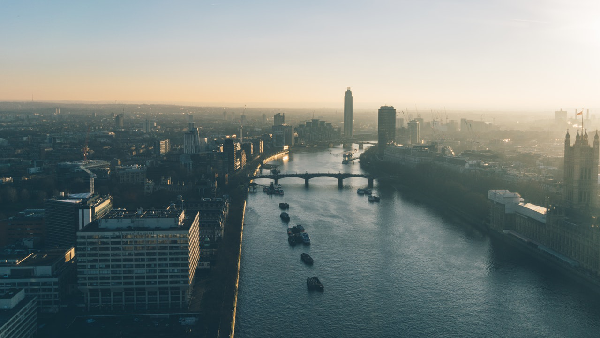

In [3]:
# After uploading the content and styles images to colab
# we open and show them

# Content image
content_image = open_image('content.jpg')
content_image

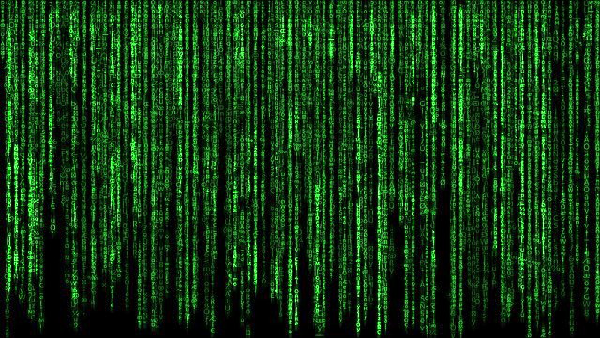

In [4]:
# Style image
style_image = open_image('matrix.jpg')
style_image

In [0]:
# Now that we have the images in memory, we need to prepare them to be processed
# First we define the functions to do the preprocess and deprocess
def preprocess_image(image):
  '''
    Apply the operations needed to make the given image suitable
    to be an input of the representation network.
    
    - First we need to convert the image to a numpy array
    - Then we need to add a dimension to match the shape that the representation
      network expects. This is because we'll use only one network instead of
      one for each image, so we need to add this dimension to combine the
      three images as input
    - Next we center the data mean by substracting to each channel 
      the mean that the channel had in the training data (the values are 
      given from the people that trained the network)
    - Finally we reverse the color channels so the images are in BGR color space
      instead of RGB
  '''
  array = np.asarray(image, dtype='float32')
  array = np.expand_dims(array, axis=0)
  array[:, :, :, 0] -= 103.939
  array[:, :, :, 1] -= 116.779
  array[:, :, :, 2] -= 123.68
  array = array[:, :, :, ::-1]
  return array

def deprocess_image(image_array):
  '''
    Inverse operation of preprocess_image. This is used at the end to have the
    image from the resulting array. The operations are as follow:
    
    - Remove the first dimension
    - Reorder the channels to RGB
    - Add the channel means
    - Make sure that the pixels end up in the interval [0, 255]
    - Create the image from the array and return it    
  '''
  image_array = image_array.reshape((height, width, 3))
  image_array = image_array[:, :, ::-1]
  image_array[:, :, 0] += 103.939
  image_array[:, :, 1] += 116.779
  image_array[:, :, 2] += 123.68
  image_array = np.clip(image_array, 0, 255).astype('uint8')
  
  return Image.fromarray(image_array)

In [0]:
# Process each image and close them
content_array = preprocess_image(content_image)
content_image.close()

style_array = preprocess_image(style_image)
style_image.close()

In [0]:
# Now we start defining the computational graph of the model
content = K.variable(content_array)
style = K.variable(style_array)
loss = K.variable(0.)
combination = K.placeholder((1, height, width, 3))

# Now we define the CNN that will be used to get the representation
# of the images using the filter responses
representation_input = K.concatenate([content, style, combination], axis=0)
representation_network = VGG16(input_tensor=representation_input, weights='imagenet', include_top=False)
representation_layers = dict([(layer.name, layer.output) for layer in representation_network.layers])

# Define layers to use to get the style and content features (filter responses)
content_feature_layer = 'block2_conv2'
style_feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

# Define the weights of the losses
content_weight = 0.05
style_weight = 5.0 / len(style_feature_layers)
total_variation_loss = 50

In [0]:
def compute_content_loss(content, combination):
    return K.sum(K.square(combination - content))

layer_features = representation_layers[content_feature_layer]
content_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

content_loss = compute_content_loss(content_features, combination_features)
loss = loss + content_weight * content_loss

In [0]:
def compute_gram_matrix(features):
    '''
      Returns the gram matrix (matrix of "correlations") of the 
      given features (filter responses)
      
      How?
      - First have the first dimension be the number of filter responses
      - Next we flatten the Width and Height dimensions to just one dimension.
        Now we have an array of values for each filter response.
      - Finally, the matrix of "correlations" is just the dot product of the
        previous matrix (vector of vectors) with its transpose. This gives
        as result a matrix with the dot products betweeen all pairs of 
        filter responses
    '''
    permuted_features = K.permute_dimensions(features, (2, 0, 1))
    flatten_features = K.batch_flatten(permuted_features)
    return K.dot(flatten_features, K.transpose(flatten_features))

def compute_style_loss(style_features, combination_features):
    '''
      Computes the style loss between the given features
    '''
    style_correlations = compute_gram_matrix(style_features)
    content_correlations = compute_gram_matrix(combination_features)
    correlation_differences = style_correlations - content_correlations
    num_channels = 3
    size = height * width
    weight_factor = 4. * (num_channels ** 2) * (size ** 2)
    return K.sum(K.square(correlation_differences)) / weight_factor

# Compute the style loss for every layer defined and add it to the total loss
for layer_name in style_feature_layers:
    layer_features = representation_layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss = loss + style_loss * style_weight

In [0]:
# In addition to content and style loss, we include an additional total 
# variation loss. This loss was not used by Gatys et al. but introduced
# by later researchers. This loss is to have a better result without much
# noise. We are just adding the difference between neighbor pixels.
# https://en.wikipedia.org/wiki/Total_variation_denoising#2D_digital_signals
def compute_total_variation_loss(x):
    a = K.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = K.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return K.sum(a + b)

loss = loss + total_variation_loss * compute_total_variation_loss(combination)

In [0]:
# Gradients of the loss with respect to the input image
gradients = K.gradients(loss, combination)

In [0]:
# Define a function that runs the computational graph created
model_inputs = [combination]
model_outputs = [loss] + gradients
model = K.function(model_inputs, model_outputs)

class Evaluator(object):
    '''
      Class for a helper object that will be used to run the model during the
      optimization
    '''

    def __init__(self):
        self.loss = None
        self.gradients = None        
       
    def compute_loss(self, image):
        image = image.reshape((1, height, width, 3))
        outputs = model([image])
        self.loss = outputs[0]
        self.gradients = outputs[1].flatten().astype('float64')
        return self.loss

    def get_gradients(self, _):
        return np.copy(self.gradients)

evaluator = Evaluator()

In [13]:
image_array = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    image_array, loss, _ = fmin_l_bfgs_b(evaluator.compute_loss, image_array.flatten(), fprime=evaluator.get_gradients, maxfun=20)
    print('Current loss value:', loss)
    end_time = time.time()
    print(f'Iteration {i} completed in {end_time - start_time}s\n')

Start of iteration 0
Current loss value: 340240630000.0
Iteration 0 completed in 17.29970121383667s

Start of iteration 1
Current loss value: 230054560000.0
Iteration 1 completed in 11.871597528457642s

Start of iteration 2
Current loss value: 170733140000.0
Iteration 2 completed in 11.871919393539429s

Start of iteration 3
Current loss value: 151902000000.0
Iteration 3 completed in 11.822989463806152s

Start of iteration 4
Current loss value: 146853300000.0
Iteration 4 completed in 11.9314546585083s

Start of iteration 5
Current loss value: 144099480000.0
Iteration 5 completed in 11.840797185897827s

Start of iteration 6
Current loss value: 142487600000.0
Iteration 6 completed in 12.004822969436646s

Start of iteration 7
Current loss value: 141466910000.0
Iteration 7 completed in 12.312352180480957s

Start of iteration 8
Current loss value: 140723130000.0
Iteration 8 completed in 12.016680240631104s

Start of iteration 9
Current loss value: 140166250000.0
Iteration 9 completed in 11.8

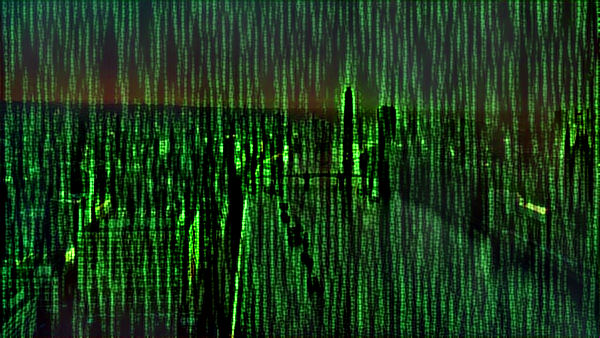

In [14]:
result = deprocess_image(image_array)
result.save('result.jpg')
result

In [0]:
result.close()